In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene

In [2]:
df = pd.read_csv("/content/drive/MyDrive/DEV/SQL/store_type.csv")

In [3]:
print(df.head(10))
print(df.info())
# 정상적으로 데이터 입력, null 값 없음

  day_type   sales
0      공휴일  153.71
1      공휴일  153.71
2      공휴일    2.05
3      공휴일   87.65
4      공휴일   16.50
5      공휴일   77.25
6      공휴일   46.20
7      공휴일  154.65
8      공휴일   46.35
9      공휴일   50.96
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day_type  52924 non-null  object 
 1   sales     52924 non-null  float64
dtypes: float64(1), object(1)
memory usage: 827.1+ KB
None


MYSQL DB에서 아래의 쿼리로 데이터를 추출  
해덩 데이터는 날짜를 기준으로 평일, 주말(토일), 공휴일 로 나누고   
각 그룹의 매출을 평균, 분산을 구하여 각 그룹들이 차이가 있는지 검정하기 위한 작업을 pandas로 진행

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

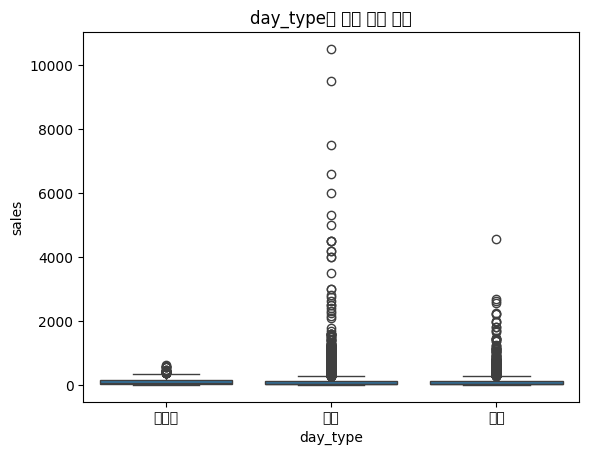

In [6]:
# 기본 시각화
# 범주형 변수와 연속형 변수의 관계를 잘 표현할 수 있는 박스플롯으로 진행

sns.boxplot(x = 'day_type', y = 'sales', data=df)
plt.title('day_type에 따른 매출 분포')
plt.show()

In [8]:
# spiro 검증로 정규성 검증
# 4. 정규성 검정 (Shapiro-Wilk)
for group in df['day_type'].unique():
    stat, p = shapiro(df[df['day_type'] == group]['sales'])
    print(f"[정규성검정] {group} → p-value: {p:.4f}")

#정규성 검증에서 p-value가 0.05보다 작으므로 정규성을 만족하지 못한다
# 세 그룹 모두 현재 정규 분포를 따르지 않는다
# 정규성이 만족하지 않기 때문에 ANOVA 검정은 불확실할 수 있으나 표본의 수(5,000건 이상)가 크기 때문에 중심극한정리로 AVONA 해석 가능


[정규성검정] 공휴일 → p-value: 0.0000
[정규성검정] 평일 → p-value: 0.0000
[정규성검정] 주말 → p-value: 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35425.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16696.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
# 5. 등분산성 검정 (Levene's Test)
levene_stat, levene_p = levene(
    df[df['day_type'] == '평일']['sales'],
    df[df['day_type'] == '주말']['sales'],
    df[df['day_type'] == '공휴일']['sales']
)
print(f"[등분산성검정] p-value: {levene_p:.4f}")

# p-value가 0.05보다 작기 때문에 등분산 조건을 만족하지 못한다
# 세 그룹의 분산이 모두 다름 -> 일반 ANOVA 검정이 아닌  Welch’s ANOVA 사용 필요

[등분산성검정] p-value: 0.0000


In [12]:
# 6. 분산분석 (ANOVA)
model = ols('sales ~ C(day_type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\n[ANOVA 결과]")
print(anova_table)

# F값이 크고 p-value가 작기 때문에 귀무가설인 모든 그룹의 평균은 같다라는 가설을 기각
# 세 그룹 중 하나 또는 이상의 평균은 유의미하게 다르다는 결론 가능


[ANOVA 결과]
                   sum_sq       df          F        PR(>F)
C(day_type)  9.999773e+05      2.0  18.603617  8.382832e-09
Residual     1.422299e+09  52921.0        NaN           NaN


In [13]:
# 7. 사후검정 (Tukey's HSD)
tukey = pairwise_tukeyhsd(endog=df['sales'], groups=df['day_type'], alpha=0.05)
print("\n[Tukey 사후검정 결과]")
print(tukey)

# ANOVA 검증의 해석
# 공휴일과 주말 그리고 주말과 평일의 매출의 차이는 유의미 하다 ( 즉, 공휴일과 주말의 매출 차이가 난다, 그리고 주말과 평일의 매출 차이가 난다)
# 공휴일과 평일의 매출 차이는 있지만 통계적으로 유의미 하지 않기 때문에 공휴일이나 평일은 비슷하다




[Tukey 사후검정 결과]
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   공휴일     주말 -16.8984 0.0121 -30.7799 -3.0168   True
   공휴일     평일  -7.9563 0.3621 -21.6684  5.7559  False
    주말     평일   8.9421    0.0   5.3352 12.5491   True
-----------------------------------------------------


In [17]:
# 등분산 조건을 만족하지 못했기 때문에 Welch’s ANOVA
!pip install pingouin
import pingouin as pg



     Source  ddof1        ddof2         F         p-unc       np2
0  day_type      2  2228.555306  25.24553  1.440002e-11  0.000703


In [19]:

# Welch's ANOVA
welch = pg.welch_anova(dv='sales', between='day_type', data=df)
print(welch)

# F값이 크고 P-value(p-unc 값)이 매우 작아 모든 그룹의 평균이 동일하다는 귀무가설 기각
# 주말, 공휴일, 평일 간의 매출의 차이는 유의미 하나, 효과의 크기(np2)값이 매우 적다
# 매출의 차이는 있으나 효과의 크기는 작아 실무적으로 효과가 없을 가능성이 높다



     Source  ddof1        ddof2         F         p-unc       np2
0  day_type      2  2228.555306  25.24553  1.440002e-11  0.000703


In [18]:
# Games-Howell 사후검정
gh = pg.pairwise_gameshowell(dv='sales', between='day_type', data=df)
print(gh)

# 앞의 Tukey 사후검정 결과와 비슷하게 나타났다
# 효과의 크기를 나타내는 hedges 값이 매우 적어 유의미 하지만 효과는 작다

     A   B    mean(A)    mean(B)       diff        se         T            df  \
0  공휴일  주말  98.911270  82.012899  16.898371  4.040045  4.182719    915.271386   
1  공휴일  평일  98.911270  90.955018   7.956252  4.021238  1.978558    898.479472   
2   주말  평일  82.012899  90.955018  -8.942119  1.392292 -6.422591  42725.763187   

           pval    hedges  
0  9.353953e-05  0.128804  
1  1.180943e-01  0.045027  
2  3.703605e-10 -0.054318  


전체적으로 차이는 존재하고 통계적으로 유의미 하지만 효과의 크기가 미미하여  
날짜를 기준으로 평일, 주말, 공휴일로 나누는 것은 크게 의미가 없을 가능성이 높다